# Traffic Accident Exploratory Data Analysis

**Auteurs:** Koen van der Hoeven & Lars Tovar  
**Opleiding:** HBO-ICT, Hogeschool Windesheim  
**Vak:** Machine Learning

---
## Onderzoeksvraag

**Kunnen we met Machine Learning voorspellen of een verkeersongeval 'Slight', 'Serious' of 'Fatal' is, op basis van omgevings- en wegkenmerken uit de UK Road Safety dataset (2005-2017)?**

### Deelvragen

1. Welke omgevings- en wegkenmerken zijn beschikbaar in de dataset?
2. Welke features correleren het sterkst met de ernst van een ongeval?
3. Welk ML-algoritme presteert het beste voor deze classificatietaak?

---
## 1. Imports

In [1]:
# show version numbers of libraries

# Python -> use platform and sys modules
import platform, sys
print(f"Python: {platform.platform()}, version: {sys.version[0:6]}")

# data science libraries
import numpy as np
import pandas as pd
import seaborn as sns
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")

# plotting library
import matplotlib as mp
print(f"matplotlib: {mp.__version__}")
import matplotlib.pyplot as plt
# ML-models library
import sklearn as sk
print(f"scikit-learn: {sk.__version__}")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# statistics library
import statsmodels
print(f"statsmodels: {statsmodels.__version__}")


Python: Windows-11-10.0.26200-SP0, version: 3.14.2
numpy: 2.4.0
pandas: 2.3.3
seaborn: 0.13.2
matplotlib: 3.10.8
scikit-learn: 1.8.0
statsmodels: 0.14.6


---
## 2. Data Loading
De dataset bevat ongeveer ~2 miljoen rijen. We laden 100.000 rijen voor performance terwijl we statistische relevantie behouden.


In [2]:
file_path = "./data/Accident_Information.csv"
df = pd.read_csv(file_path, nrows=100000)
df.head()

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
0,200501BS00001,A,3218,NaN,0.0,Serious,NaN,2005-01-04,Tuesday,1.0,...,Metropolitan Police,Wet or damp,Single carriageway,NaN,30,17:42,Urban,Raining no high winds,2005,No
1,200501BS00002,B,450,C,0.0,Slight,NaN,2005-01-05,Wednesday,1.0,...,Metropolitan Police,Dry,Dual carriageway,NaN,30,17:36,Urban,Fine no high winds,2005,No
2,200501BS00003,C,0,NaN,0.0,Slight,NaN,2005-01-06,Thursday,1.0,...,Metropolitan Police,Dry,Single carriageway,NaN,30,00:15,Urban,Fine no high winds,2005,No
3,200501BS00004,A,3220,NaN,0.0,Slight,NaN,2005-01-07,Friday,1.0,...,Metropolitan Police,Dry,Single carriageway,NaN,30,10:35,Urban,Fine no high winds,2005,No
4,200501BS00005,Unclassified,0,NaN,0.0,Slight,NaN,2005-01-10,Monday,1.0,...,Metropolitan Police,Wet or damp,Single carriageway,NaN,30,21:13,Urban,Fine no high winds,2005,No


### 2. Data Cleaning and Preprocessing
Focusing on data types, missing values, and feature engineering.

In [3]:
# Convert Date and Time
df['Date'] = pd.to_datetime(df['Date'])
df['Hour'] = df['Time'].str.split(':').str[0].astype(float)

# Check for missing values
missing_data = df.isnull().sum()
print("Missing values per column:")
print(missing_data[missing_data > 0])

# Filter for numeric analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns identified: {numeric_cols}")

Missing values per column:
2nd_Road_Class                                 35816
2nd_Road_Number                                  434
Carriageway_Hazards                            98421
Did_Police_Officer_Attend_Scene_of_Accident      162
Latitude                                          31
Location_Easting_OSGR                             31
Location_Northing_OSGR                            31
Longitude                                         31
LSOA_of_Accident_Location                        111
Pedestrian_Crossing-Human_Control                 13
Pedestrian_Crossing-Physical_Facilities           17
Special_Conditions_at_Site                     97721
Time                                               1
Hour                                               1
dtype: int64

Numeric columns identified: ['1st_Road_Number', '2nd_Road_Number', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Latitude', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Number_of_Casualties', 'Nu

---
## 3. Data Exploration (EDA)

### 3.1 Target Variabele: Accident_Severity

Onze target variabele is `Accident_Severity` met drie klassen:
- **Slight** - Licht letsel
- **Serious** - Ernstig letsel  
- **Fatal** - Dodelijk

### 3.2 Distribution Analysis (Histograms)
Visualizing the frequency of key numeric variables.

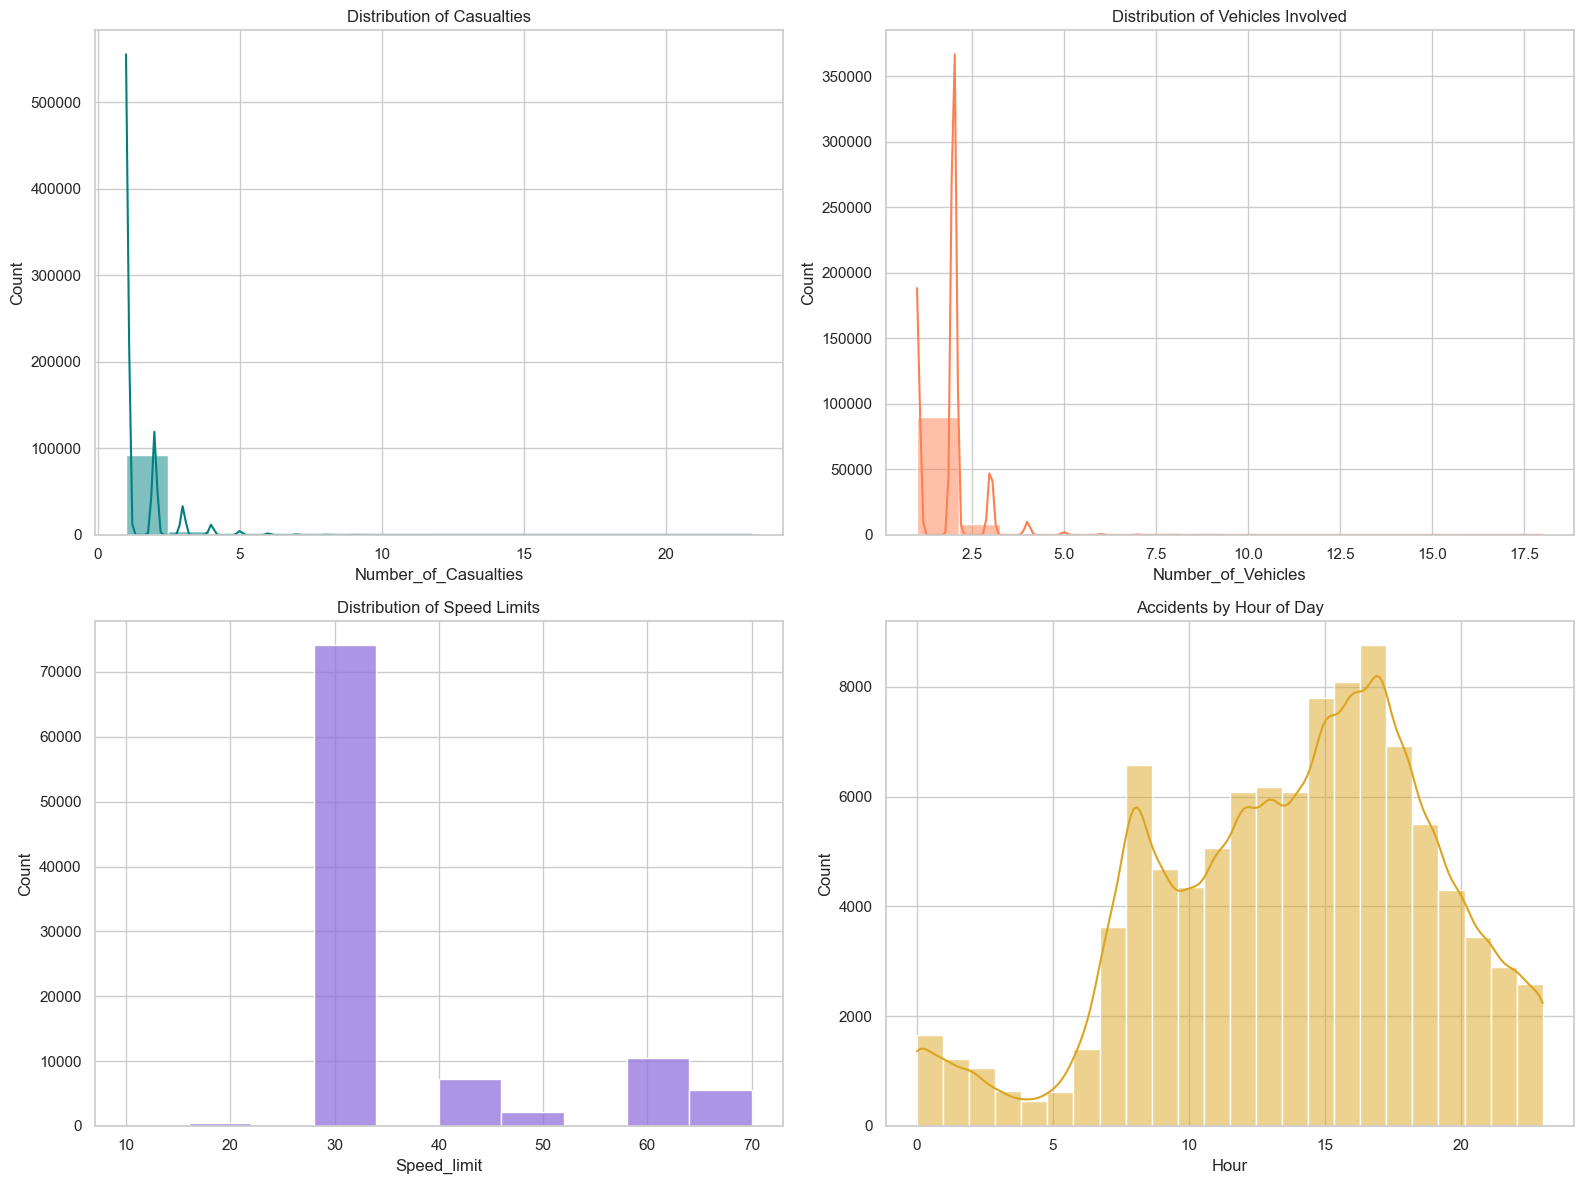

In [4]:
# set some default plotting styles
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(df['Number_of_Casualties'], bins=15, kde=True, ax=axes[0, 0], color='teal')
axes[0, 0].set_title('Distribution of Casualties')

sns.histplot(df['Number_of_Vehicles'], bins=15, kde=True, ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Distribution of Vehicles Involved')

sns.histplot(df['Speed_limit'].dropna(), bins=10, kde=False, ax=axes[1, 0], color='mediumpurple')
axes[1, 0].set_title('Distribution of Speed Limits')

sns.histplot(df['Hour'].dropna(), bins=24, kde=True, ax=axes[1, 1], color='goldenrod')
axes[1, 1].set_title('Accidents by Hour of Day')

plt.tight_layout()
plt.show()


**Observatie Casualties**
- Meestal is het 1 gewonde.

**Observatie Vehicles**
- Meestal zijn er twee voertuigen betrokken bij een ongeval.

**Observatie Speed limit**
- 30 mph gebeuren de meeste ongelukken.

**Observatie Hour**
- Gedurende de spitsuren gebeuren de meeste ongelukken.

### 3.3 Numerieke Variablen
Correlatie matrix voor de numerieke features


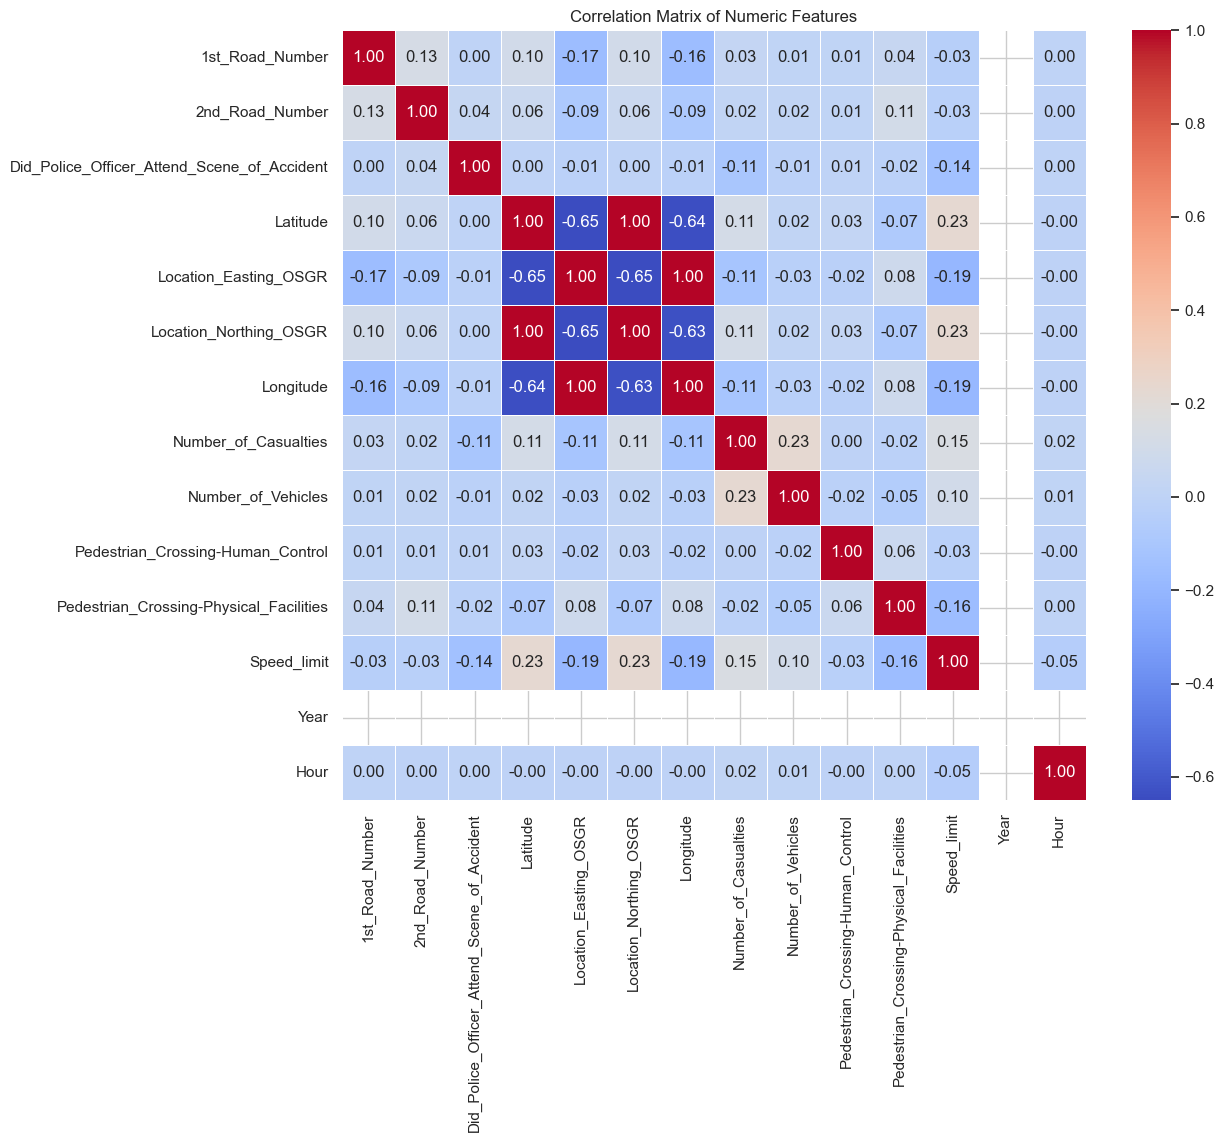

In [5]:
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()


Deze heatmap toont de correlaties tussen numerieke variabelen.

**Sterke correlaties (bruikbaar)**

Latitude en longitude correleren sterk negatief met location easting / northing (r = −0.65). Dit is logisch, aangezien het alternatieve coördinatensystemen zijn. Wij zullen daarom slechts één van deze gebruiken.

Het aantal voertuigen correleert positief met het aantal slachtoffers (r = 0.23). Dit betekent dat wanneer er meer voertuigen bij een ongeval betrokken zijn, het verwachte aantal slachtoffers toeneemt.

Speed limit en latitude vertonen eveneens een correlatie (r = 0.23). Dit suggereert dat snelheidslimieten variëren per geografisch gebied.

**Zwakke correlaties**

Wij classificeren correlaties als zwak wanneer r kleiner is dan 0.15. De meeste variabelen vallen in deze categorie, wat geen probleem vormt. We verwachten niet dat één enkele variabele het volledige probleem kan verklaren.

Hour vertoont geen lineaire correlatie met andere features. Dit betekent echter niet dat Hour onbelangrijk is. Zoals te zien is in de eerdere histogrammen, is de relatie niet-lineair. Daarom is feature engineering nodig om deze variabele effectief te kunnen gebruiken.




### 3.4. Relationship Exploration (Scatterplots)
Visualizing interactions between pairs of variables.

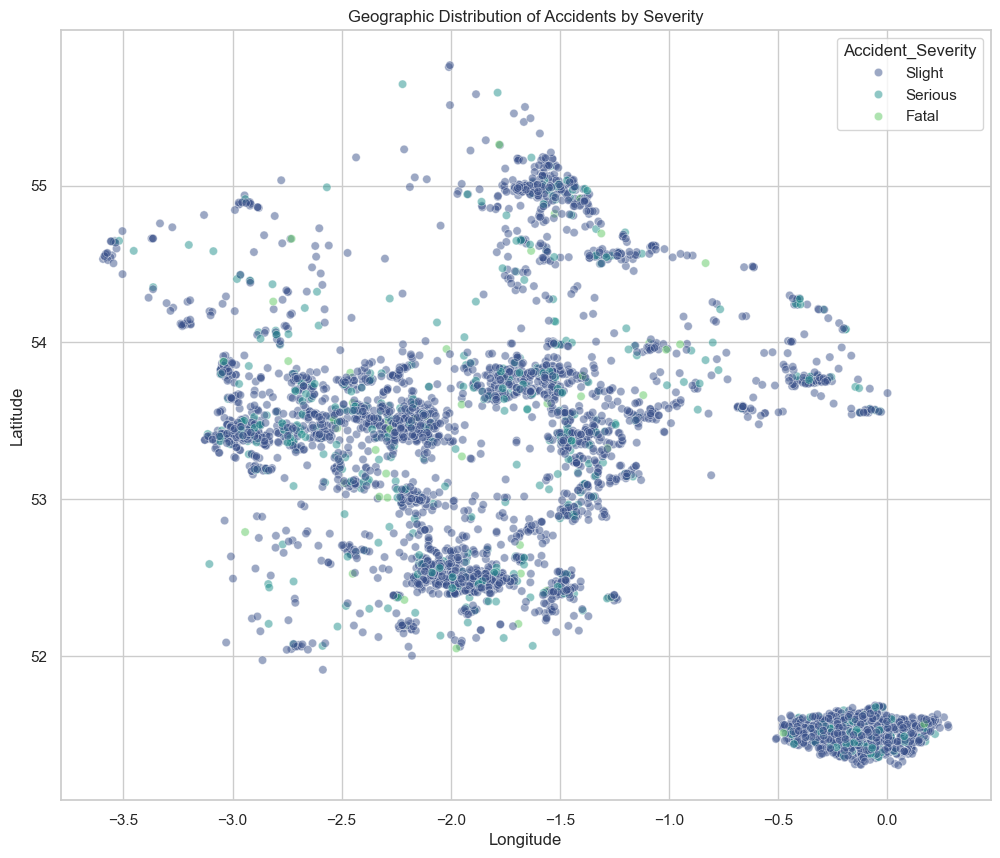

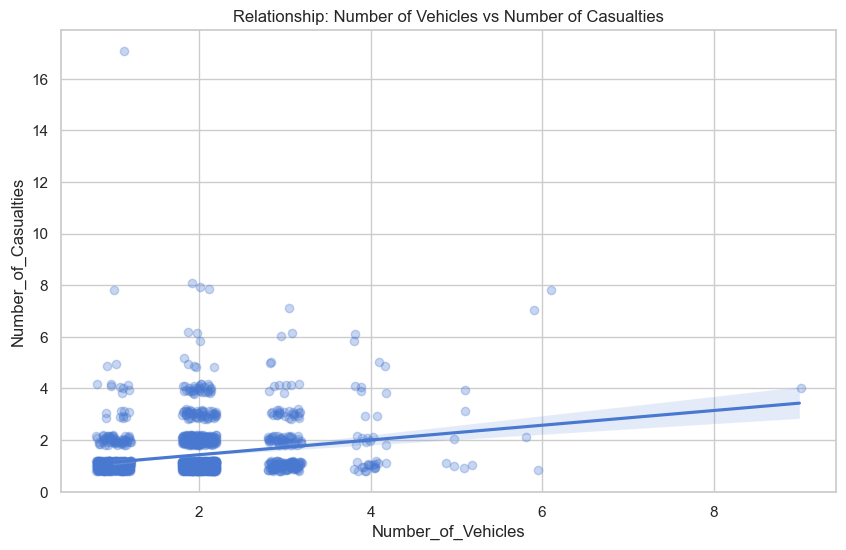

In [6]:
# Geografische scatterplot bij accident severity
plt.figure(figsize=(12, 10))
sns.scatterplot(x='Longitude', y='Latitude', hue='Accident_Severity', 
                data=df.sample(5000), alpha=0.5, palette='viridis')
plt.title('Geographic Distribution of Accidents by Severity')
plt.show()

# Relatie tussen aantal voertuigen en aantal slachtoffers
plt.figure(figsize=(10, 6))
sns.regplot(x='Number_of_Vehicles', y='Number_of_Casualties', data=df.sample(2000), 
            x_jitter=0.2, y_jitter=0.2, scatter_kws={'alpha':0.3})
plt.title('Relationship: Number of Vehicles vs Number of Casualties')
plt.show()

**Geographic Scatterplot**  
De scatterplot toont ongevallen in het Verenigd Koninkrijk. Er zijn duidelijke clusters zichtbaar rondom grote steden zoals Londen, Yorkshire en in het noordwesten van Engeland (regio Manchester/Liverpool).

**Vehicles and Casualties**  
Er is een positieve lineaire relatie tussen het aantal voertuigen en het aantal slachtoffers. Hoe meer voertuigen bij een ongeval betrokken zijn, hoe meer slachtoffers er doorgaans vallen. Dit is te zien aan de stijgende lijn in de grafiek.



### 3.5. Categorical Insights
Analyzing the impact of environmental factors.

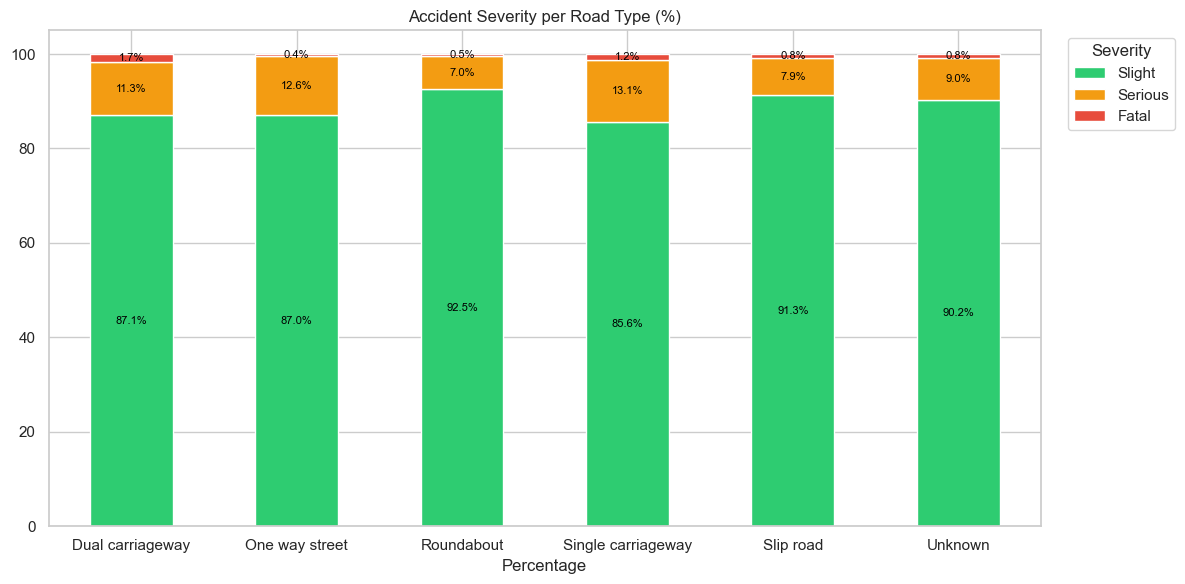

In [7]:
# accident severity per road type
severity_order = ['Slight', 'Serious', 'Fatal']
colors = ['#2ecc71', '#f39c12', '#e74c3c']

ct = pd.crosstab(df['Road_Type'], df['Accident_Severity'], normalize='index') * 100
ct = ct.reindex(columns=severity_order)

ax = ct.plot(kind='bar', stacked=True, color=colors, figsize=(12, 6))

# Add percentage labels
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center', fontsize=8, color='black')

plt.title('Accident Severity per Road Type (%)')
plt.xlabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Severity', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

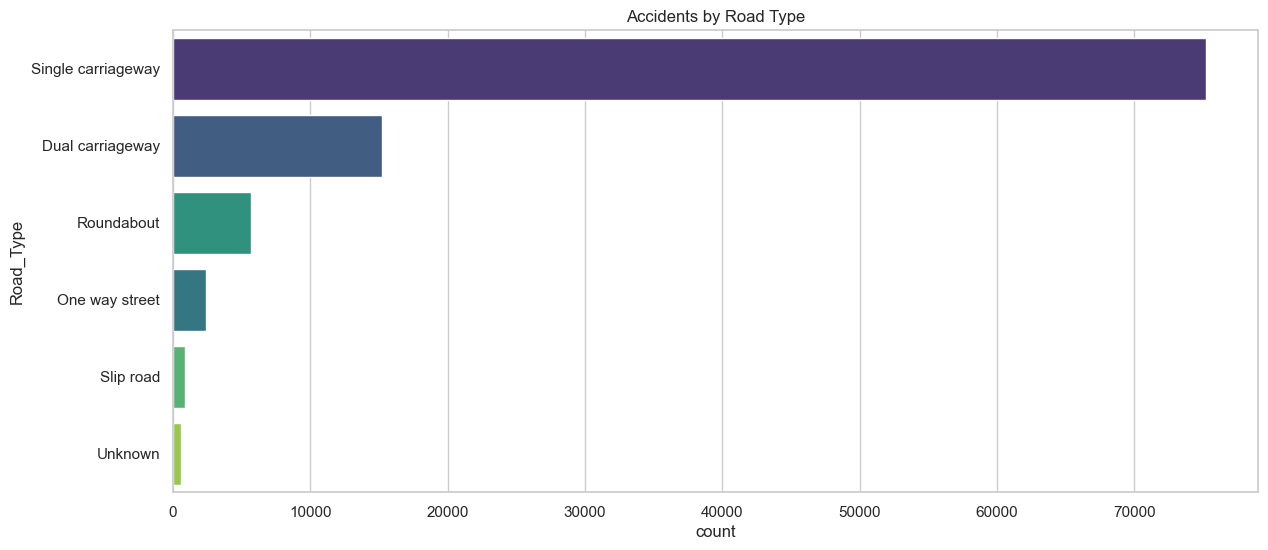

In [8]:
plt.figure(figsize=(14, 6))
sns.countplot(y='Road_Type', data=df, order=df['Road_Type'].value_counts().index, hue='Road_Type', palette='viridis', legend=False)
plt.title('Accidents by Road Type')
plt.show()

**Observatie Road Type:**
- Single carriageway: ~75.000 ongevallen
- Dual carriageway: ~15.000 ongevallen
- Roundabout: ~7.000 ongevallen

**Impact op model:** Hoog bruikbaar. Verschillende wegtypes hebben verschillende risicoprofielen.

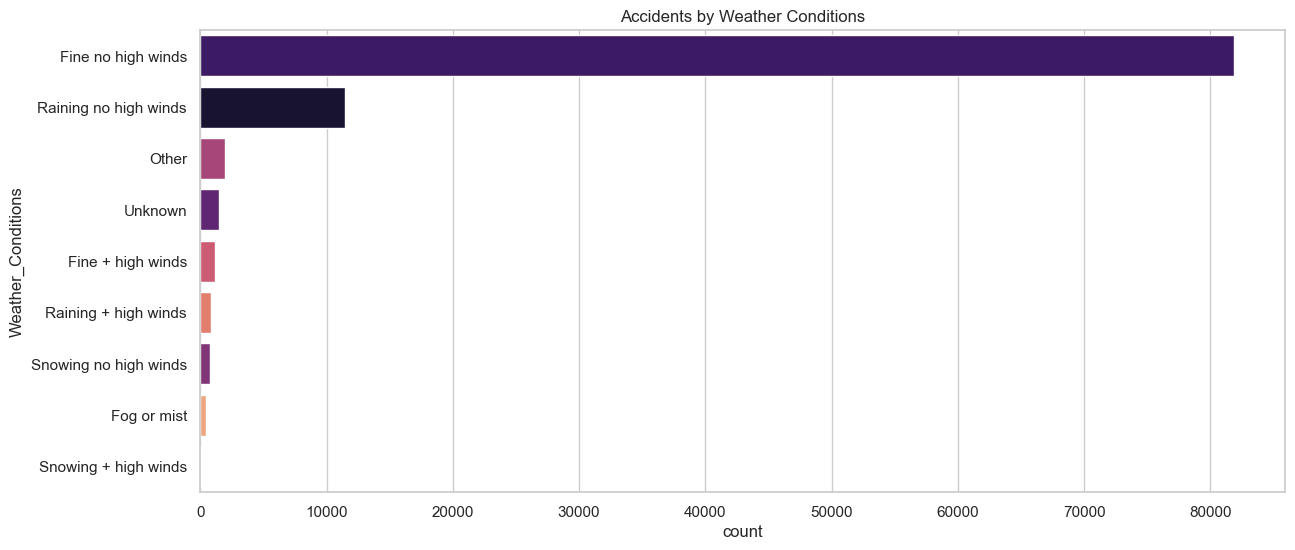

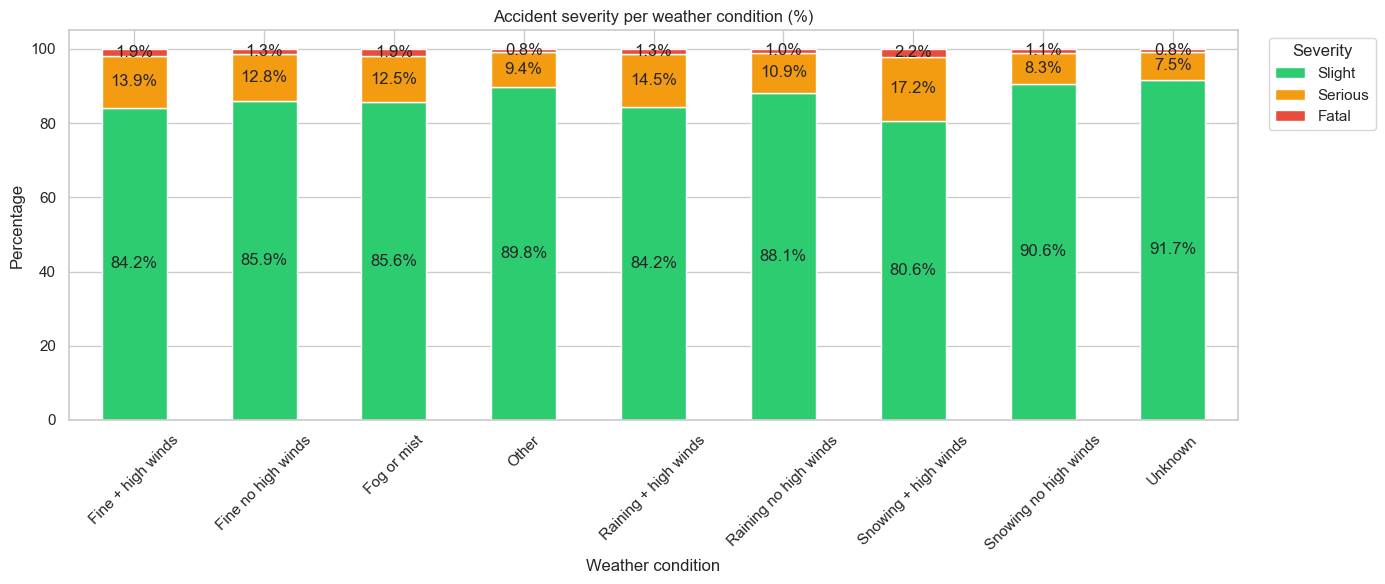

In [9]:
plt.figure(figsize=(14, 6))
sns.countplot(y='Weather_Conditions', data=df, order=df['Weather_Conditions'].value_counts().index, hue='Weather_Conditions', palette='magma', legend=False)
plt.title('Accidents by Weather Conditions')
plt.show()

ct = pd.crosstab(df['Weather_Conditions'], df['Accident_Severity'], normalize='index') * 100
ct = ct.reindex(columns=severity_order)

ax = ct.plot(kind='bar', stacked=True, color=colors, figsize=(14, 6))
ax.set(title='Accident severity per weather condition (%)',
       xlabel='Weather condition', ylabel='Percentage')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Severity', bbox_to_anchor=(1.02, 1))

for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()

**Observatie Weather Conditions:**
- ~80.000 ongevallen bij goed weer (Fine no winds)  
- ~12.000 ongevallen bij regen  
Dit lijkt op een contradictie maar is hoogst waarscheinlijk exposure bias omdat het vaker beter weer is of dat meer mensen rijden als het weer mooi is.  

**Impact op model:** Mid-high bruikbaarheid. Regen/mist/sneeuw kunnen impact hebben op severity.

### 3.6 Temporele Analyse

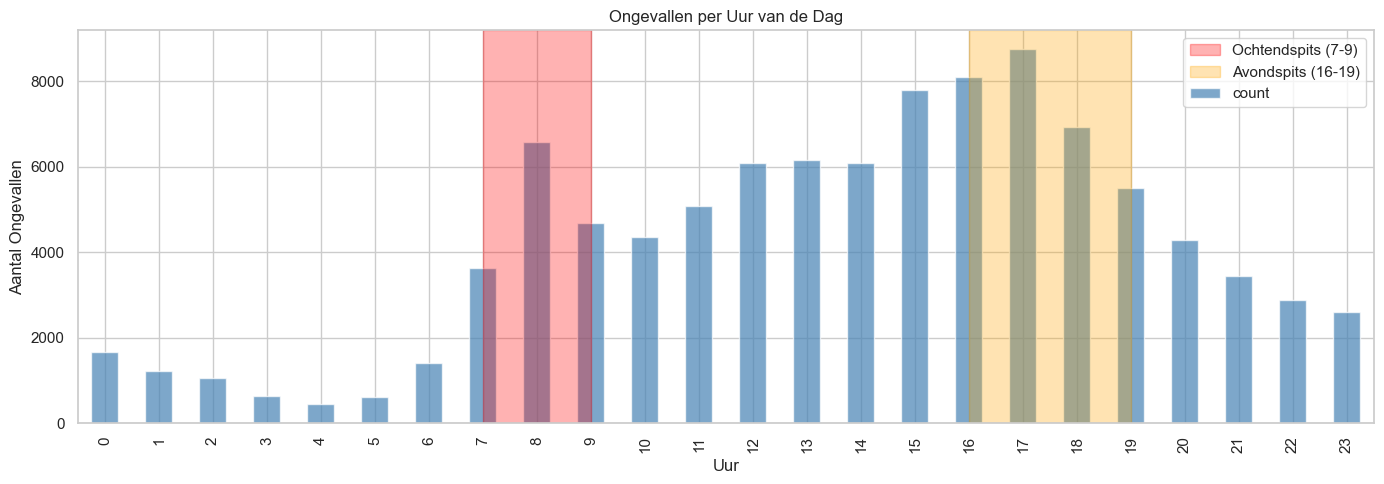

In [10]:
# Ongevallen per uur
plt.figure(figsize=(14, 5))

# Histogram per uur
df['Hour'].dropna().astype(int).value_counts().sort_index().plot(kind='bar', color='steelblue', alpha=0.7)
plt.axvspan(7, 9, alpha=0.3, color='red', label='Ochtendspits (7-9)')
plt.axvspan(16, 19, alpha=0.3, color='orange', label='Avondspits (16-19)')
plt.title('Ongevallen per Uur van de Dag')
plt.xlabel('Uur')
plt.ylabel('Aantal Ongevallen')
plt.legend()
plt.tight_layout()
plt.show()

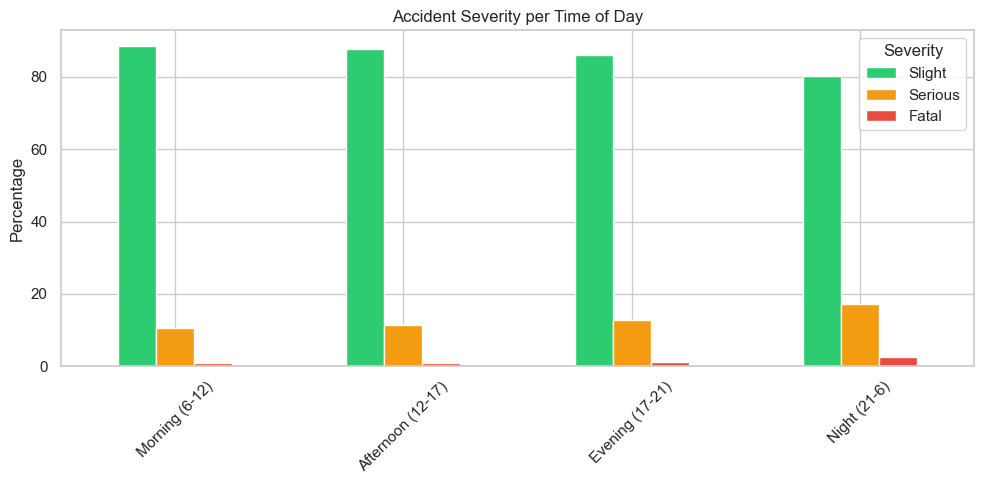


Percentages per dagdeel:
Accident_Severity  Slight  Serious  Fatal
Time_Category                            
Morning (6-12)      88.37    10.69   0.93
Afternoon (12-17)   87.65    11.42   0.94
Evening (17-21)     86.08    12.77   1.15
Night (21-6)        80.15    17.23   2.62


In [11]:
# Severity per tijd van de dag
def time_category(hour):
    if pd.isna(hour):
        return 'Unknown'
    elif 6 <= hour < 12:
        return 'Morning (6-12)'
    elif 12 <= hour < 17:
        return 'Afternoon (12-17)'
    elif 17 <= hour < 21:
        return 'Evening (17-21)'
    else:
        return 'Night (21-6)'

df['Time_Category'] = df['Hour'].apply(time_category)

ct_time = pd.crosstab(df['Time_Category'], df['Accident_Severity'], normalize='index') * 100
ct_time = ct_time.reindex(columns=severity_order)
time_order = ['Morning (6-12)', 'Afternoon (12-17)', 'Evening (17-21)', 'Night (21-6)']
ct_time = ct_time.reindex(time_order)

ct_time.plot(kind='bar', color=colors, figsize=(10, 5))
plt.title('Accident Severity per Time of Day')
plt.ylabel('Percentage')
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

print("\nPercentages per dagdeel:")
print(ct_time.round(2))

**Observatie Temporeel:**
- Nachtelijke ongevallen (21-6) hebben het hoogste percentage Fatal en Serious
- Dit komt waarschijnlijk door verminderd zicht, moeheid en mogelijk alcoholgebruik

**Impact op model:** Hoog bruikbaar - tijd van de dag is een sterke predictor.

### 3.7 Speed Limit Analyse

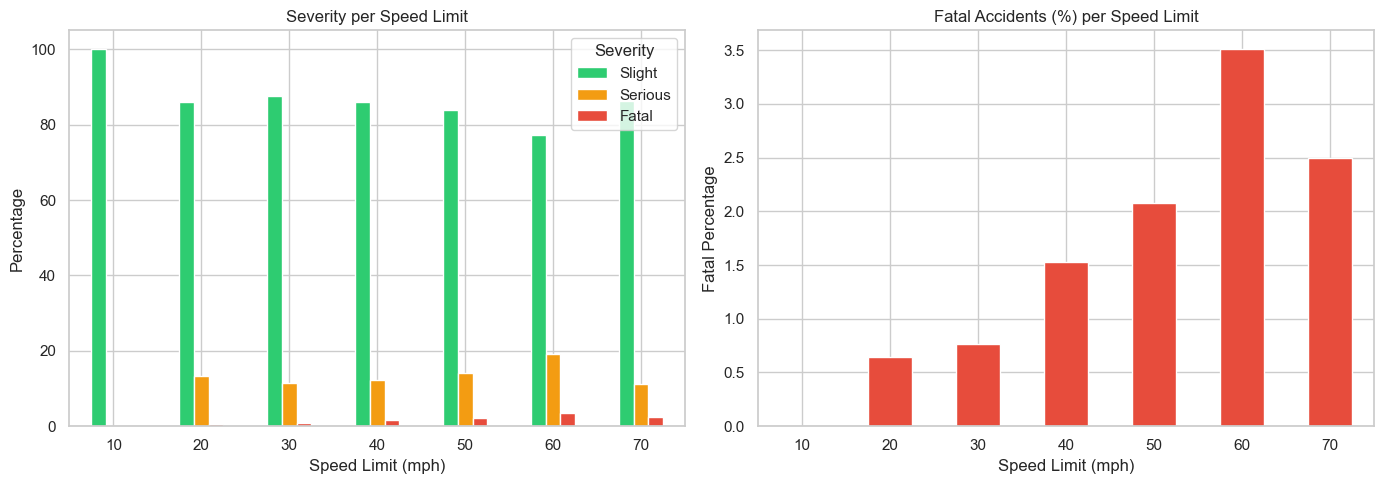


Fatal percentage per speed limit:
Speed_limit
10    0.00
20    0.64
30    0.77
40    1.53
50    2.08
60    3.51
70    2.50
Name: Fatal, dtype: float64


In [12]:
# Speed limit vs Severity
ct_speed = pd.crosstab(df['Speed_limit'], df['Accident_Severity'], normalize='index') * 100
ct_speed = ct_speed.reindex(columns=severity_order)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ct_speed.plot(kind='bar', color=colors, ax=axes[0])
axes[0].set_title('Severity per Speed Limit')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('Speed Limit (mph)')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Severity')

# Fatal percentage alleen
ct_speed['Fatal'].plot(kind='bar', color='#e74c3c', ax=axes[1])
axes[1].set_title('Fatal Accidents (%) per Speed Limit')
axes[1].set_ylabel('Fatal Percentage')
axes[1].set_xlabel('Speed Limit (mph)')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\nFatal percentage per speed limit:")
print(ct_speed['Fatal'].round(2))


**Observatie Speed Limit:**
- Duidelijke correlatie: hogere snelheidslimiet → hogere kans op Fatal/Serious
- 70 mph wegen hebben ~4x hoger Fatal percentage dan 30 mph wegen

**Impact op model:** Zeer hoog bruikbaar - een van de sterkste predictors.

### 3.8 Urban vs Rural Analyse

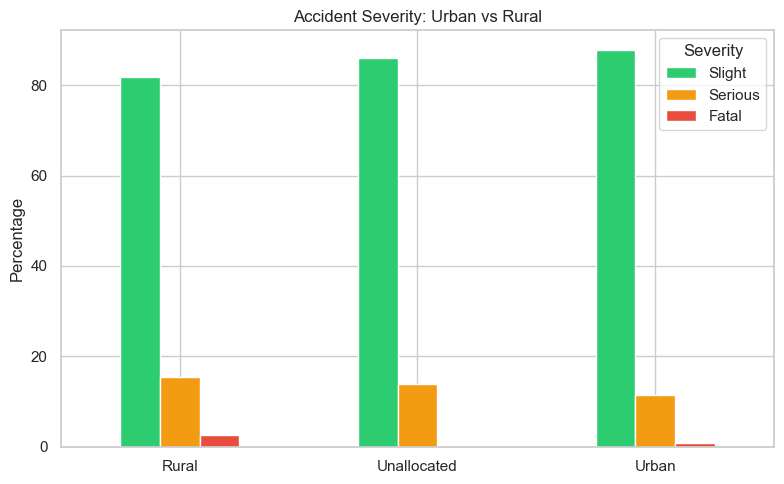

Percentages:
Accident_Severity    Slight  Serious  Fatal
Urban_or_Rural_Area                        
Rural                 81.87    15.54   2.59
Unallocated           86.11    13.89   0.00
Urban                 87.72    11.46   0.82


In [13]:
# Urban vs Rural
ct_area = pd.crosstab(df['Urban_or_Rural_Area'], df['Accident_Severity'], normalize='index') * 100
ct_area = ct_area.reindex(columns=severity_order)

ct_area.plot(kind='bar', color=colors, figsize=(8, 5))
plt.title('Accident Severity: Urban vs Rural')
plt.ylabel('Percentage')
plt.xlabel('')
plt.xticks(rotation=0)
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

print("Percentages:")
print(ct_area.round(2))

**Observatie Urban vs Rural:**
- Landelijke gebieden hebben een hoger percentage Serious en Fatal ongevallen
- Dit komt waarschijnlijk door hogere snelheidslimieten op landelijke wegen

**Impact op model:** Hoog bruikbaar als feature.

### 3.9 Light conditions Analyse

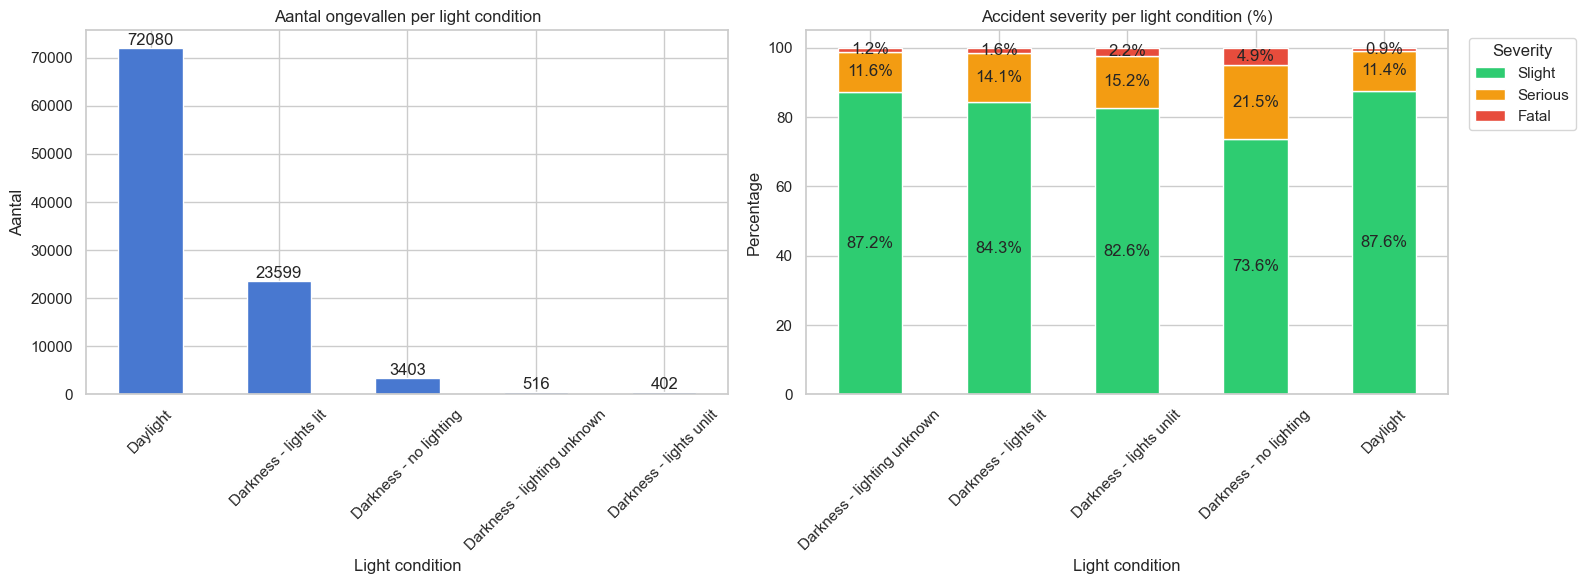

In [14]:
counts = df['Light_Conditions'].value_counts()
ct = pd.crosstab(df['Light_Conditions'], df['Accident_Severity'], normalize='index') * 100
ct = ct.reindex(columns=severity_order)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Aantallen
counts.plot(kind='bar', ax=ax[0])
ax[0].set(title='Aantal ongevallen per light condition', xlabel='Light condition', ylabel='Aantal')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0])

# Severity %
ct.plot(kind='bar', stacked=True, color=colors, ax=ax[1])
ax[1].set(title='Accident severity per light condition (%)', xlabel='Light condition', ylabel='Percentage')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend(title='Severity', bbox_to_anchor=(1.02, 1))
for c in ax[1].containers: ax[1].bar_label(c, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()


**Observatie Light conditions**
- Dark en geen licht heeft hoogste Fatal percentage
- Verminderd zicht leidt tot ernstigere botsingen (geen tijd om te remmen)

**Impact op model:** Hoog bruikbaar als feature.

### 3.10 Road class Analyse

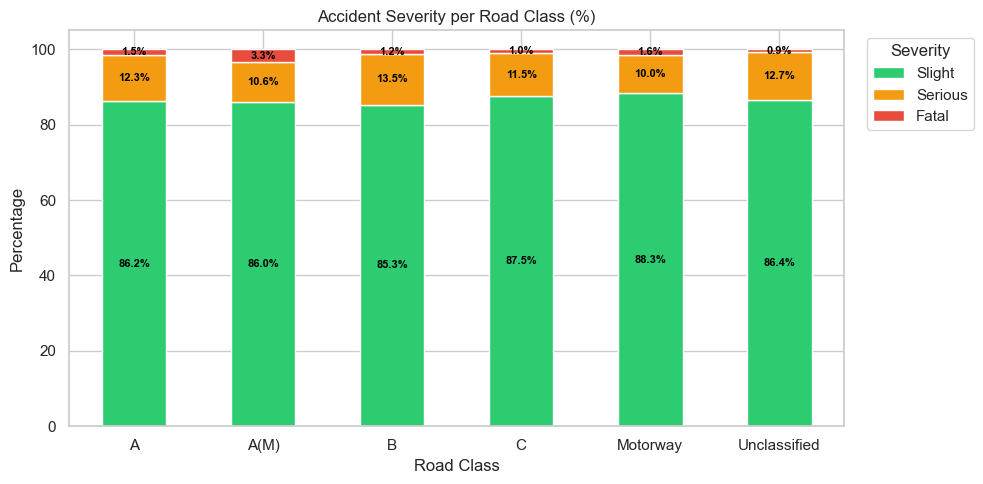

In [15]:
ct_roadclass = pd.crosstab(df['1st_Road_Class'], df['Accident_Severity'], normalize='index') * 100
ct_roadclass = ct_roadclass.reindex(columns=severity_order)

ax = ct_roadclass.plot(kind='bar', stacked=True, color=colors, figsize=(10, 5))
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center', fontsize=8, color='black', fontweight='bold')

plt.title('Accident Severity per Road Class (%)')
plt.xlabel('Road Class')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Severity', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

**Observatie Road Class:**
- A-wegen hebben hoger Fatal % waarschijnlijk door hogere snelheden
- Motorways (M) tonen ook verhoogd risico

**Impact op model**  
Mid-hoog

### 3.11 Day of the week

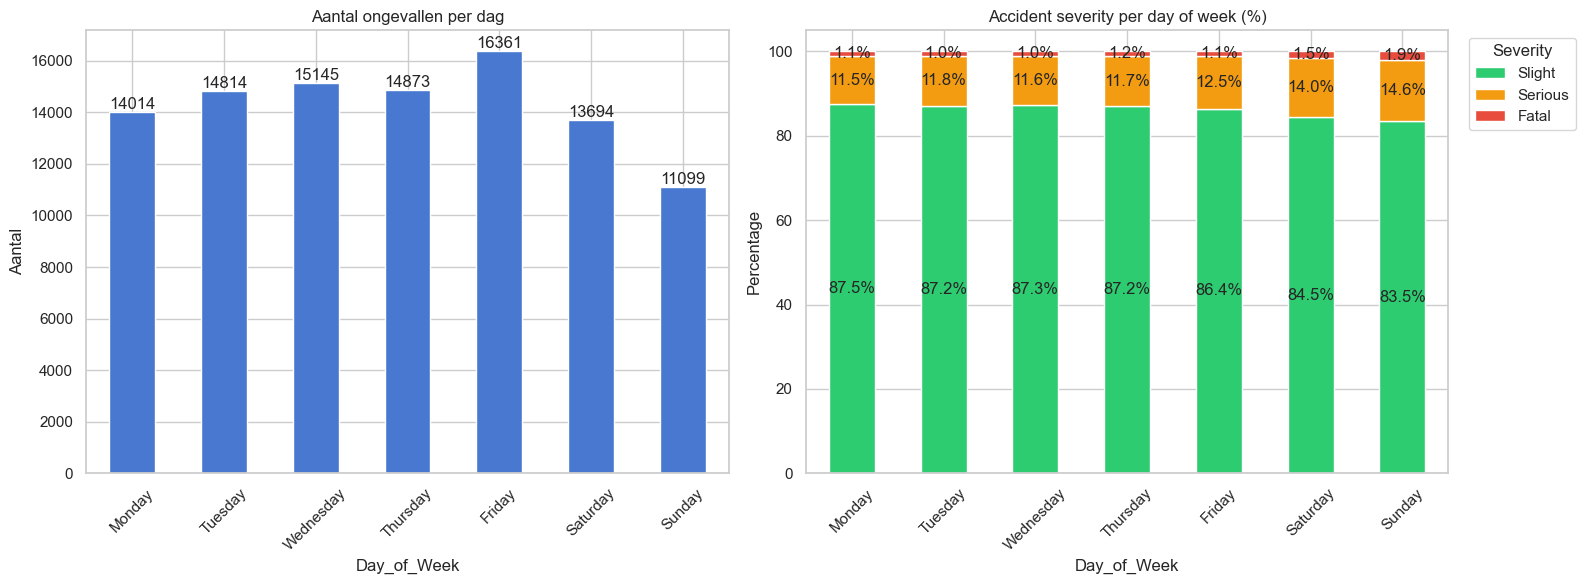

In [16]:
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

counts = df['Day_of_Week'].value_counts().reindex(day_order)
ct = pd.crosstab(df['Day_of_Week'], df['Accident_Severity'], normalize='index') * 100
ct = ct.reindex(index=day_order, columns=severity_order)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Aantal per dag
counts.plot(kind='bar', ax=ax[0])
ax[0].set(title='Aantal ongevallen per dag', ylabel='Aantal')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0])

# Severity %
ct.plot(kind='bar', stacked=True, color=colors, ax=ax[1])
ax[1].set(title='Accident severity per day of week (%)', ylabel='Percentage')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend(title='Severity', bbox_to_anchor=(1.02, 1))
for c in ax[1].containers:
    ax[1].bar_label(c, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()

**Observatie dag van de week**
- Weekend (za/zo) heeft iets hogere Fatal percentage
- Mogelijk door recreatief rijden en alcoholgebruik
- Verschil is klein maar consistent  

**Impact op model:** Mid bruikbaar als feature.

### 3.12 Junction detail

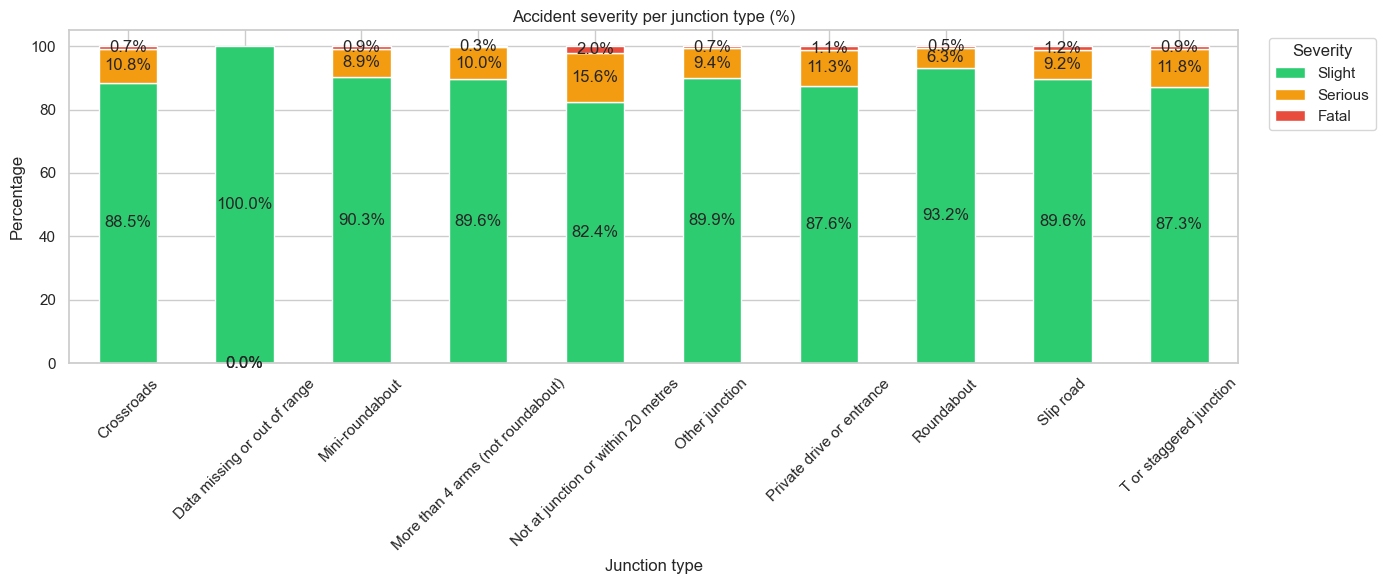

In [17]:
ct = pd.crosstab(df['Junction_Detail'], df['Accident_Severity'], normalize='index') * 100
ct = ct.reindex(columns=severity_order)

ax = ct.plot(kind='bar', stacked=True, color=colors, figsize=(14, 6))
ax.set(title='Accident severity per junction type (%)', xlabel='Junction type', ylabel='Percentage')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Severity', bbox_to_anchor=(1.02, 1))

for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()


**Observatie Junction Detail**
- Verschillende junction types hebben verschillende risicoprofielen
- Not at junction heeft hogere fatality rate (hogere snelheden op doorgaande weg)

**Impact op model:** Mid-Hoog bruikbaar als feature.

### 3.13 EDA Conclusie

| Feature | Bruikbaarheid | Reden |
|---------|--------------|-------|
| Speed_limit |  Zeer hoog | Duidelijke correlatie met severity |
| Road_Type |  Zeer hoog | Verschillende risicoprofielen |
| Urban_or_Rural_Area |  Zeer hoog | Rural = ernstiger |
| Hour/Time |  Zeer hoog | Nacht = ernstiger |
| Light_Conditions |  Hoog | Zichtbaarheid |
| Weather_Conditions |  Mid-hoog | Impact op grip en zicht |
| Road_Surface_Conditions |  Mid-hoog | Nat/droog wegdek |
| Junction_Detail | Mid | Verschillende risicoprofiel per kruispunt |
| 1st_Road_Class | Mid | A wegen hoger dan B wegen |
| Day_of_Week | Low | Iets hogere fatal % op weekenden vs weekdagen |

---
## 4. Data Preperation

#### 4.1 Encoding  

Categorische variablen zetten wij om naar numerieke representaties ervan.  
Scheiden van targets & features daarna data bewerken en one hot encoden.

In [18]:
#target en features scheiden
target = 'Accident_Severity'
X = df.drop(columns=[target])
y = df[target]


#drop ID column
X = X.drop(columns=["Accident_Index"], errors="ignore")
#encoder kan niet met dataTime omgaan dus omzetten.
X["Date"] = pd.to_datetime(X["Date"], errors="coerce")
X["DayOfWeek_fromDate"] = X["Date"].dt.dayofweek
X = X.drop(columns=["Date"])
# drop Time en maak Hour en Minute kolommen
t = pd.to_datetime(X["Time"], format="%H:%M", errors="coerce")
X["Hour"] = t.dt.hour
X = X.drop(columns=["Time"])

# missing values in categorische kolommen vullen met 'Unknown'
cat_cols = X.select_dtypes(include=["object", "category"]).columns
X[cat_cols] = X[cat_cols].fillna("Unknown")

# dit is ML best practice omdat median beter is bij outliers
num_cols = X.select_dtypes(include=[np.number]).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# Drop alle dubbele en onnodige kollomen.
drop_cols = [
    # Sommige kollomen werden als categorisch gezien maar hebben veel unieke waarden.
    'LSOA_of_Accident_Location', 'Local_Authority_(District)',
    'Local_Authority_(Highway)', 'Police_Force',
    '1st_Road_Number', '2nd_Road_Number',
    
    # Data leakage
    'Number_of_Casualties', 'Number_of_Vehicles',
    'Did_Police_Officer_Attend_Scene_of_Accident',
    
    # Redundante locatie (Lat/Long is genoeg)
    'Location_Easting_OSGR', 'Location_Northing_OSGR',
    
    # Redundant met DayOfWeek_fromDate
    'Day_of_Week',
    
    # Redundant met Hour (wordt Time_Category na encoding)
    'Time_Category'
]
X = X.drop(columns=drop_cols, errors='ignore')


X_encoded = pd.get_dummies(X, drop_first=True)

# check of alles omgezet is naar numeriek of bool.
non_numeric = X_encoded.select_dtypes(exclude=["number", "bool"]).columns
print("Dit moet een lege list zijn", list(non_numeric))

# wij merkte tijdens het maken van het model dat er veel features waren en dat er dubbele features waren,
# toen zijn we terug gegaan naar dit bestand om alle engineered features weg te gooien en onnodige kollomen te verwijderen.
# Daarom printen we alle features om te kijken wat er over is gebleven.
print(f"Totaal aantal features: {len(X_encoded.columns)}")
print("\nAlle features:")
print(X_encoded.columns.tolist())

Dit moet een lege list zijn []
Totaal aantal features: 71

Alle features:
['Latitude', 'Longitude', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Speed_limit', 'Year', 'Hour', 'DayOfWeek_fromDate', '1st_Road_Class_A(M)', '1st_Road_Class_B', '1st_Road_Class_C', '1st_Road_Class_Motorway', '1st_Road_Class_Unclassified', '2nd_Road_Class_A(M)', '2nd_Road_Class_B', '2nd_Road_Class_C', '2nd_Road_Class_Motorway', '2nd_Road_Class_Unclassified', '2nd_Road_Class_Unknown', 'Carriageway_Hazards_Data missing or out of range', 'Carriageway_Hazards_Other object on road', 'Carriageway_Hazards_Pedestrian in carriageway - not injured', 'Carriageway_Hazards_Previous accident', 'Carriageway_Hazards_Unknown', 'Carriageway_Hazards_Vehicle load on road', 'Junction_Control_Auto traffic signal', 'Junction_Control_Data missing or out of range', 'Junction_Control_Give way or uncontrolled', 'Junction_Control_Not at junction or within 20 metres', 'Junction_Control_Stop sign', 'Jun

#### 4.2 Target Encoding  

In [19]:
severity_mapping = {
    'Slight': 0,
    'Serious': 1,
    'Fatal': 2
}

y = y.map(severity_mapping)



#### 4.3 Train, test en validatie split maken

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, #4.3 gebruik nu de encoded features
    y,
    test_size=0.4,      # 40% tijdelijk we gaan hier test en val van maken
    random_state=42,
    stratify=y
)



X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,      # helft van 40% -> 20% / 20%
    random_state=42,
    stratify=y_temp
)

# Get feature names after encoding to use at export.
feature_names = X_train.columns

#### 4.4 Scaling  

Zet features op gelijke schaal waardoor verschillende waarden niet voor geen reden belangrijker zijn.  
 Dit doen wij voor Koen's logistische regressie en zou niet veel uitmaken voor random forest en daarom doe we het voor de gehele dataset.

In [21]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (60000, 71)
Validation shape: (20000, 71)
Test shape: (20000, 71)


Hier zien we dat we 71 features gebruiken om onze modellen te trainen.

#### 4.5 Exporteer de sets

In [22]:
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_val_df   = pd.DataFrame(X_val, columns=feature_names)
X_test_df  = pd.DataFrame(X_test, columns=feature_names)

X_train_df.to_csv('train_set.csv', index=False)
X_val_df.to_csv('validation_set.csv', index=False)
X_test_df.to_csv('test_set.csv', index=False)

y_train.to_csv("y_train.csv", index=False)
y_val.to_csv("y_val.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

---
## Verdeling van de uitwerking.

| Teamlid | Model | Notebook |
|---------|-------|----------|
| Koen | Logistic Regression | logistische_regressie.ipynb |
| Lars | Random Forest | random_forest.ipynb |